In [ ]:
import pandas as pd
from pathlib import Path

# correct folder path
data_dir = Path(r"C:\Users\aryas\OneDrive\Desktop\infosys-project\data")

# pick one file to start with (city_day.csv)
file_path = data_dir / "city_day.csv"

df = pd.read_csv(file_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape: (29531, 16)
Columns: ['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [ ]:
# convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# sort by City + Date
df = df.sort_values(['City', 'Date']).reset_index(drop=True)

# quick checks
print("Date range:", df['Date'].min(), "to", df['Date'].max())
print("Unique cities:", df['City'].nunique())
print("Sample cities:", df['City'].unique()[:10])
df.head()


Date range: 2015-01-01 00:00:00 to 2020-07-01 00:00:00
Unique cities: 26
Sample cities: ['Ahmedabad' 'Aizawl' 'Amaravati' 'Amritsar' 'Bengaluru' 'Bhopal'
 'Brajrajnagar' 'Chandigarh' 'Chennai' 'Coimbatore']


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [ ]:
# Check % of missing values per column
missing_percent = df.isna().mean() * 100
print("Missing value % per column:")
print(missing_percent.sort_values(ascending=False))


Missing value % per column:
Xylene        61.322001
PM10          37.723071
NH3           34.973418
Toluene       27.229014
Benzene       19.041008
AQI           15.851139
AQI_Bucket    15.851139
PM2.5         15.570079
NOx           14.171549
O3            13.619586
SO2           13.050692
NO2           12.139785
NO            12.129626
CO             6.972334
City           0.000000
Date           0.000000
dtype: float64


In [ ]:
# Step 5: Handle missing values

# Drop columns with too much missing (e.g., >50%)
drop_cols = ['Xylene']   # we drop this for now
df = df.drop(columns=drop_cols)

# Group by city and fill missing with forward/backward fill
df = df.groupby('City').apply(lambda group: group.ffill().bfill()).reset_index(drop=True)

# Check missing after fill
missing_after = df.isna().mean() * 100
print("Missing % after fill:")
print(missing_after.sort_values(ascending=False))


Missing % after fill:
Toluene       13.578951
Benzene        9.251295
PM10           6.803021
NH3            6.803021
NOx            3.958552
O3             0.548576
City           0.000000
Date           0.000000
PM2.5          0.000000
NO             0.000000
NO2            0.000000
CO             0.000000
SO2            0.000000
AQI            0.000000
AQI_Bucket     0.000000
dtype: float64


C:\Users\aryas\AppData\Local\Temp\ipykernel_25232\2775213623.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('City').apply(lambda group: group.ffill().bfill()).reset_index(drop=True)


In [ ]:
import numpy as np

# Ensure index is datetime
df.index = pd.to_datetime(df.index)

# Identify numeric pollutant columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

def resample_city(city_df):
    numeric_part = (city_df[numeric_cols]
                    .resample('D')
                    .mean()
                    .ffill()
                    .bfill())
    numeric_part['City'] = city_df['City'].iloc[0]
    return numeric_part

# Resample city-wise
df_resampled = (
    df.groupby('City', group_keys=False)
      .apply(resample_city)
      .reset_index()
)

# Rename the index column to "Date"
df_resampled = df_resampled.rename(columns={'index': 'Date'})

print("Columns now:", df_resampled.columns.tolist())
print("Shape after resampling:", df_resampled.shape)
print("Date range:", df_resampled['Date'].min(), "to", df_resampled['Date'].max())

df_resampled.head()


Columns now: ['Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'AQI', 'City']
Shape after resampling: (26, 14)
Date range: 1970-01-01 00:00:00 to 1970-01-01 00:00:00


C:\Users\aryas\AppData\Local\Temp\ipykernel_25232\4283608400.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(resample_city)


,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI,City
0,1970-01-01,92.980224,136.119487,17.946491,47.434689,41.755495,NaN,17.782997,53.282220,38.936984,5.325326,24.226884,420.483823,Ahmedabad
1,1970-01-01,16.850531,23.200973,9.408053,0.388496,12.610354,22.308938,0.283628,7.378053,3.534336,11.849115,12.254513,34.778761,Aizawl
2,1970-01-01,36.280631,73.642482,5.153544,21.721651,15.252734,12.533586,0.600673,14.335258,37.313859,0.692093,2.945825,91.950578,Amaravati
3,1970-01-01,53.366896,117.482801,18.703890,18.576798,32.480188,14.284398,0.555897,7.566871,22.536896,3.805225,2.822957,119.908272,Amritsar
4,1970-01-01,35.149388,80.882847,9.394052,27.962992,19.687372,24.540567,1.841095,5.512882,33.331239,4.602703,4.690821,94.302140,Bengaluru


In [ ]:
print(df.columns)


Index(['index', 'City', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO',
       'SO2', 'O3', 'Benzene', 'Toluene', 'AQI', 'AQI_Bucket'],
      dtype='object')


In [ ]:
import pandas as pd

# If 'index' column is supposed to be your Date column
df.rename(columns={'index': 'Date'}, inplace=True)

# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Check the result
print(df.head())
print(df.info())


                           Date       City  PM2.5    PM10     NO    NO2  \
0 1970-01-01 00:00:00.000000000  Ahmedabad  73.24  141.54   0.92  18.22   
1 1970-01-01 00:00:00.000000001  Ahmedabad  73.24  141.54   0.97  15.69   
2 1970-01-01 00:00:00.000000002  Ahmedabad  73.24  141.54  17.40  19.30   
3 1970-01-01 00:00:00.000000003  Ahmedabad  73.24  141.54   1.70  18.48   
4 1970-01-01 00:00:00.000000004  Ahmedabad  73.24  141.54  22.10  21.42   

     NOx  NH3     CO    SO2      O3  Benzene  Toluene    AQI AQI_Bucket  
0  17.15  NaN   0.92  27.64  133.36     0.00     0.02  209.0       Poor  
1  16.46  NaN   0.97  24.55   34.06     3.68     5.50  209.0       Poor  
2  29.70  NaN  17.40  29.07   30.70     6.80    16.40  209.0       Poor  
3  17.97  NaN   1.70  18.59   36.08     4.43    10.14  209.0       Poor  
4  37.76  NaN  22.10  39.33   39.31     7.01    18.89  209.0       Poor  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 15 column

In [ ]:
# Count missing values in each column
print(df.isnull().sum())


Date             0
City             0
PM2.5            0
PM10          2009
NO               0
NO2              0
NOx           1169
NH3           2009
CO               0
SO2              0
O3             162
Benzene       2732
Toluene       4010
AQI              0
AQI_Bucket       0
dtype: int64


In [ ]:
df['PM10'] = df['PM10'].fillna(df['PM10'].mean())
df['NOx'] = df['NOx'].fillna(df['NOx'].mean())
df['NH3'] = df['NH3'].fillna(df['NH3'].mean())


In [ ]:
df = df.sort_values(by='Date')


In [ ]:
# Fill missing numeric values with column mean
for col in ['PM10', 'NOx', 'NH3', 'O3', 'Benzene', 'Toluene']:
    df[col] = df[col].fillna(df[col].mean())


In [ ]:
print(df.isnull().sum())


Date          0
City          0
PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
AQI           0
AQI_Bucket    0
dtype: int64


In [ ]:
df = df.sort_values(by='Date')
df.set_index('Date', inplace=True)


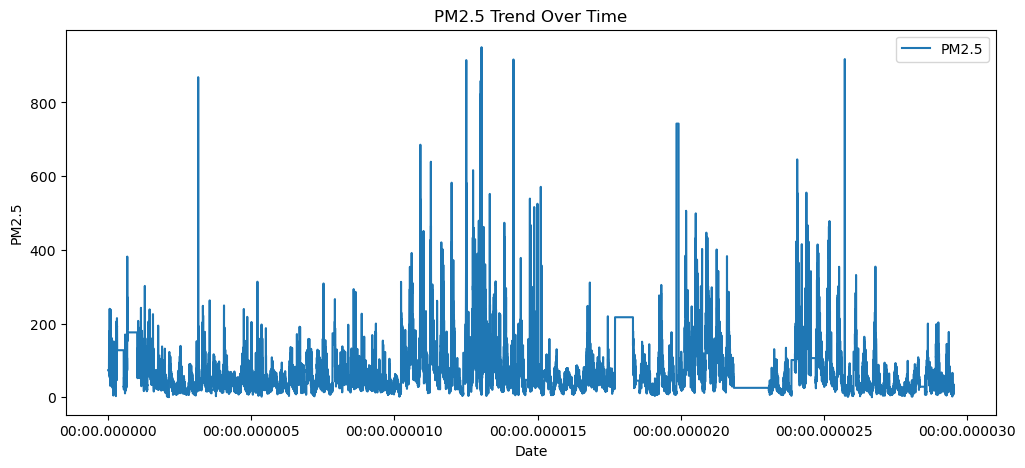

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df['PM2.5'], label='PM2.5')
plt.title('PM2.5 Trend Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.show()


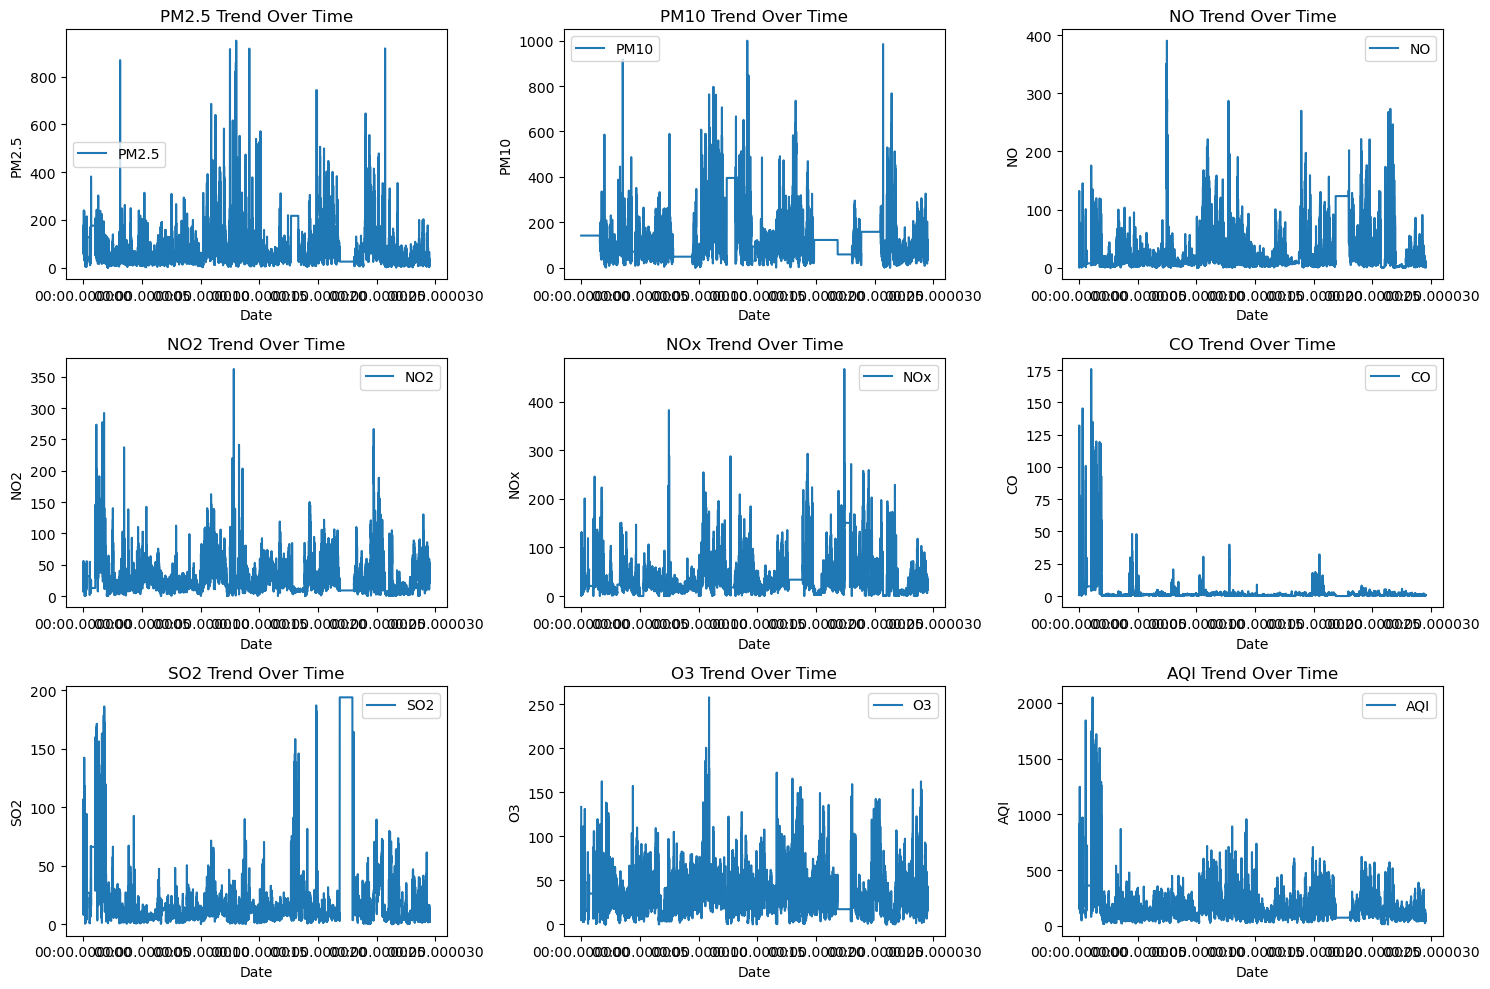

In [ ]:
import matplotlib.pyplot as plt

# List of columns to plot
pollutants = ['PM2.5','PM10','NO','NO2','NOx','CO','SO2','O3','AQI']

plt.figure(figsize=(15, 10))

for i, col in enumerate(pollutants, 1):
    plt.subplot(3, 3, i)  # 3x3 grid of plots
    plt.plot(df[col], label=col)
    plt.title(f'{col} Trend Over Time')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.tight_layout()

plt.show()


In [ ]:
plt.savefig('pollutants_trends.png', dpi=300)


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def preprocess_air_quality(file_path, save_path):
    # 1️Load CSV
    df = pd.read_csv(file_path)
    
    # 2️Clean column names
    df.columns = df.columns.str.strip()
    if 'index' in df.columns:
        df.rename(columns={'index': 'Date'}, inplace=True)
    
    # 3️Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    
    # 4️ Sort and set Date as index
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)
    
    # 5️ Resample daily and forward-fill missing values
    df_daily = df.resample('D').mean()
    df_daily = df_daily.ffill()
    
    # 6️ Fill missing numeric values with mean (if any left)
    numeric_cols = df_daily.select_dtypes(include='number').columns
    for col in numeric_cols:
        df_daily[col] = df_daily[col].fillna(df_daily[col].mean())
    
    # 7️ Normalize pollutant columns
    pollutants = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','AQI']
    pollutants = [col for col in pollutants if col in df_daily.columns]
    scaler = MinMaxScaler()
    df_daily[pollutants] = scaler.fit_transform(df_daily[pollutants])
    
    # 8️ Handle outliers (clip to 1st and 99th percentile)
    for col in pollutants:
        lower = df_daily[col].quantile(0.01)
        upper = df_daily[col].quantile(0.99)
        df_daily[col] = df_daily[col].clip(lower, upper)
    
    #  Feature engineering: day of week, month, season
    df_daily['DayOfWeek'] = df_daily.index.dayofweek
    df_daily['Month'] = df_daily.index.month
    df_daily['Season'] = df_daily['Month'].apply(lambda x: (x%12 + 3)//3)  # 1=Winter, 2=Spring, 3=Summer, 4=Autumn
    
    # 10️ Save cleaned CSV
    df_daily.to_csv(save_path)
    print(f"Saved cleaned file to {save_path}")
    
    return df_daily


In [ ]:
# --- Separate numeric and non-numeric columns ---
numeric_cols = df.select_dtypes(include='number').columns
non_numeric_cols = df.select_dtypes(exclude='number').columns

# --- Resample numeric columns daily ---
df_daily_numeric = df[numeric_cols].resample('D').mean().ffill()

# --- Forward-fill non-numeric columns if needed ---
df_daily_non_numeric = df[non_numeric_cols].resample('D').ffill()

# --- Combine back ---
df_daily = pd.concat([df_daily_numeric, df_daily_non_numeric], axis=1)


In [ ]:
df = pd.read_csv(data_dir / 'city_day.csv', index_col=0)  # first column might be Date
print(df.head())
print(df.index)


                 Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
City                                                                         
Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
Ahmedabad  2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
Ahmedabad  2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

               O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
City                                                         
Ahmedabad  133.36     0.00     0.02    0.00  NaN        NaN  
Ahmedabad   34.06     3.68     5.50    3.77  NaN        NaN  
Ahmedabad   30.70     6.80    16.40    2.25  NaN        NaN  
Ahmedabad   36.08     4.43    10.14    1.00  NaN        NaN  
Ahmedabad   39.31     7.01    18.89    2.78  NaN        NaN  
Index(['Ahmedabad',

In [ ]:
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

data_dir = Path(r"C:\Users\aryas\OneDrive\Desktop\infosys-project\data")
file_path = data_dir / 'city_day.csv'
save_path = data_dir / 'city_day_cleaned.csv'

#  Load CSV and reset index
df = pd.read_csv(file_path)
df.reset_index(drop=False, inplace=True)  # This brings 'City' and Date as columns

#  Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

#  Sort by Date and set as index
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

#  Forward-fill numeric missing values
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].ffill()

#  Normalize pollutants
pollutants = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','AQI']
pollutants = [col for col in pollutants if col in df.columns]
scaler = MinMaxScaler()
df[pollutants] = scaler.fit_transform(df[pollutants])

#  Handle outliers (clip 1st-99th percentile)
for col in pollutants:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower, upper)

#  Feature engineering
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Season'] = df['Month'].apply(lambda x: (x%12 + 3)//3)

#  Save cleaned file
df.to_csv(save_path)
print(f"Saved cleaned file to {save_path}")

# ✅ Quick check
print(df.head())
print(df.isnull().sum())


Saved cleaned file to C:\Users\aryas\OneDrive\Desktop\infosys-project\data\city_day_cleaned.csv
            index       City     PM2.5      PM10        NO       NO2  \
Date                                                                   
2015-01-01      0  Ahmedabad       NaN       NaN  0.002304  0.050276   
2015-01-01   7834    Chennai       NaN       NaN  0.041673  0.042463   
2015-01-01  10229      Delhi  0.329681  0.454182  0.176983  0.100442   
2015-01-01  19846    Lucknow  0.329681  0.454182  0.005350  0.037134   
2015-01-01  21855     Mumbai  0.329681  0.454182  0.005350  0.037134   

                 NOx       NH3        CO       SO2        O3   Benzene  \
Date                                                                     
2015-01-01  0.036674       NaN  0.005233  0.142533  0.414632  0.000000   
2015-01-01  0.048500  0.012979  0.006655  0.047408  0.044001  0.000374   
2015-01-01  0.236490  0.095897  0.086457  0.047666  0.161687  0.031558   
2015-01-01  0.009773  0.09589

In [ ]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

#  Paths
data_dir = Path(r"C:\Users\aryas\OneDrive\Desktop\infosys-project\data")
input_file = data_dir / "city_hour.csv"
output_file = data_dir / "city_hour_cleaned.csv"

# 1️ Load CSV
df = pd.read_csv(input_file)

# 2️ Standardize column names
df.columns = df.columns.str.strip()

# 3️ Convert 'Datetime' to datetime type and set as index
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df = df.sort_values('Datetime')
df.set_index('Datetime', inplace=True)

# 4️ Handle missing numeric values (forward fill)
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(method='ffill')

# 5️ Handle outliers: clip between 1st and 99th percentile
for col in numeric_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower, upper)

# 6️ Normalize pollutants (optional, but good practice)
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 7️Feature engineering: Hour, DayOfWeek, Month, Season
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month

# Season mapping: Dec-Feb: Winter, Mar-May: Summer, Jun-Aug: Monsoon, Sep-Nov: Autumn
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8]:
        return 'Monsoon'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(get_season)

# 8️⃣ Save cleaned CSV
df.to_csv(output_file)

print("city_hour.csv cleaned and saved as city_hour_cleaned.csv")
print(df.head())


C:\Users\aryas\AppData\Local\Temp\ipykernel_25232\1529991086.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df[numeric_cols].fillna(method='ffill')


city_hour.csv cleaned and saved as city_hour_cleaned.csv
                          City  PM2.5  PM10        NO       NO2       NOx  \
Datetime                                                                    
2015-01-01 01:00:00  Ahmedabad    NaN   NaN  0.003334  0.277641  0.181718   
2015-01-01 01:00:00    Chennai    NaN   NaN  0.249197  0.334149  0.286042   
2015-01-01 01:00:00      Delhi    1.0   1.0  0.491423  0.290207  0.937619   
2015-01-01 01:00:00    Lucknow    1.0   1.0  0.010972  0.081496  0.021085   
2015-01-01 01:00:00     Mumbai    1.0   1.0  0.010972  0.081496  0.121812   

                          NH3        CO       SO2        O3   Benzene  \
Datetime                                                                
2015-01-01 01:00:00       NaN  0.036377  1.000000       NaN  0.000000   
2015-01-01 01:00:00  0.033970  0.033467  0.061555  0.048077  0.003916   
2015-01-01 01:00:00  0.170754  0.337941  0.026301  0.393076  0.898540   
2015-01-01 01:00:00  0.170754  0.46998

In [ ]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

# paths
data_dir = Path(r"C:\Users\aryas\OneDrive\Desktop\infosys-project\data")
input_file = data_dir / "station_day.csv"
output_file = data_dir / "station_day_cleaned.csv"

# 1️ Load CSV
df = pd.read_csv(input_file)

# 2️Clean column names
df.columns = df.columns.str.strip()

# 3️ Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# 4️ Handle missing numeric values (forward fill)
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(method='ffill')

# 5️ Handle outliers: clip between 1st and 99th percentile
for col in numeric_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower, upper)

# 6️ Normalize pollutants
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 7️ Feature engineering: DayOfWeek, Month, Season
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8]:
        return 'Monsoon'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(get_season)

# 8️ Save cleaned CSV
df.to_csv(output_file)

print("station_day.csv cleaned and saved as station_day_cleaned.csv")
print(df.head())


C:\Users\aryas\AppData\Local\Temp\ipykernel_25232\612496988.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df[numeric_cols].fillna(method='ffill')


station_day.csv cleaned and saved as station_day_cleaned.csv
           StationId     PM2.5  PM10        NO       NO2       NOx       NH3  \
Date                                                                           
2015-01-01     DL013  0.527286   NaN  0.092297  0.075653  0.107321  0.318742   
2015-01-01     TN003  0.527286   NaN  0.035386  0.066205  0.045784  0.024241   
2015-01-01     MH005  0.527286   NaN  0.035386  0.066205  0.118821  0.024241   
2015-01-01     KA009  0.527286   NaN  0.010312  0.064114  0.030986  0.145217   
2015-01-01     TN004  0.527286   NaN  0.182848  0.148998  0.159962  0.145217   

                  CO       SO2        O3   Benzene   Toluene  Xylene  \
Date                                                                   
2015-01-01  1.000000  0.126505       NaN       NaN       NaN     NaN   
2015-01-01  0.064091  0.105795       NaN       NaN       NaN     NaN   
2015-01-01  0.000000  0.105795       NaN  0.000000  0.000000     0.0   
2015-01-01  0.0541

In [ ]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

# ✅ Paths
data_dir = Path(r"C:\Users\aryas\OneDrive\Desktop\infosys-project\data")
input_file = data_dir / "station_hour.csv"
output_file = data_dir / "station_hour_cleaned.csv"

# 1️⃣ Load CSV
df = pd.read_csv(input_file)

# 2️⃣ Clean column names
df.columns = df.columns.str.strip()

# 3️⃣ Convert 'Datetime' to datetime and set as index
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df = df.sort_values('Datetime')
df.set_index('Datetime', inplace=True)

# 4️⃣ Handle missing numeric values (forward fill)
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(method='ffill')

# 5️⃣ Handle outliers: clip between 1st and 99th percentile
for col in numeric_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower, upper)

# 6️⃣ Normalize pollutants
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 7️⃣ Feature engineering: DayOfWeek, Month, Season, Hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Hour'] = df.index.hour

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8]:
        return 'Monsoon'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(get_season)

# 8️⃣ Save cleaned CSV
df.to_csv(output_file)

print("station_hour.csv cleaned and saved as station_hour_cleaned.csv")
print(df.head())


C:\Users\aryas\AppData\Local\Temp\ipykernel_25232\283860497.py:11: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)
C:\Users\aryas\AppData\Local\Temp\ipykernel_25232\283860497.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df[numeric_cols].fillna(method='ffill')


station_hour.csv cleaned and saved as station_hour_cleaned.csv
                    StationId  PM2.5  PM10        NO       NO2       NOx  \
Datetime                                                                   
2015-01-01 01:00:00     TN003    NaN   NaN  0.033728  0.057350  0.038857   
2015-01-01 01:00:00     DL033    NaN   NaN  0.552625  0.229763  0.718943   
2015-01-01 01:00:00     MH005    NaN   NaN  0.552625  0.229763  0.079944   
2015-01-01 01:00:00     KA003    NaN   NaN  0.004850  0.082892  0.027741   
2015-01-01 01:00:00     DL021    NaN   NaN  0.004850  0.387885  1.000000   

                          NH3        CO       SO2        O3   Benzene  \
Datetime                                                                
2015-01-01 01:00:00  0.035949  0.060959  0.083356       NaN       NaN   
2015-01-01 01:00:00  0.035949  0.060959  0.002460  0.010332  0.909296   
2015-01-01 01:00:00  0.035949  0.000000  0.002460  0.010332  0.000000   
2015-01-01 01:00:00  0.035949  0.013014

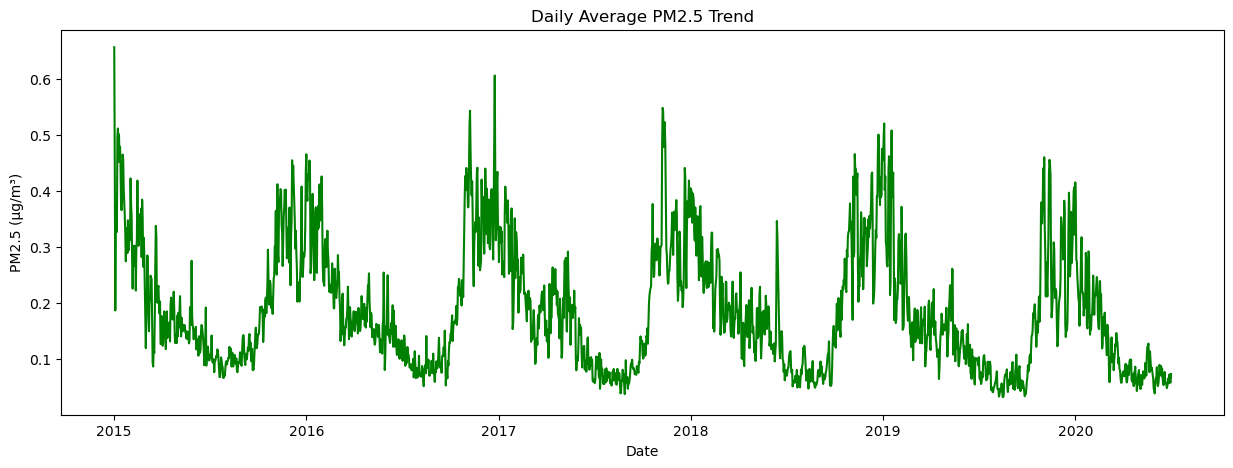

In [ ]:
# Daily average
daily_pm25 = df['PM2.5'].resample('D').mean()

plt.figure(figsize=(15,5))
plt.plot(daily_pm25, color='green')
plt.title("Daily Average PM2.5 Trend")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.show()


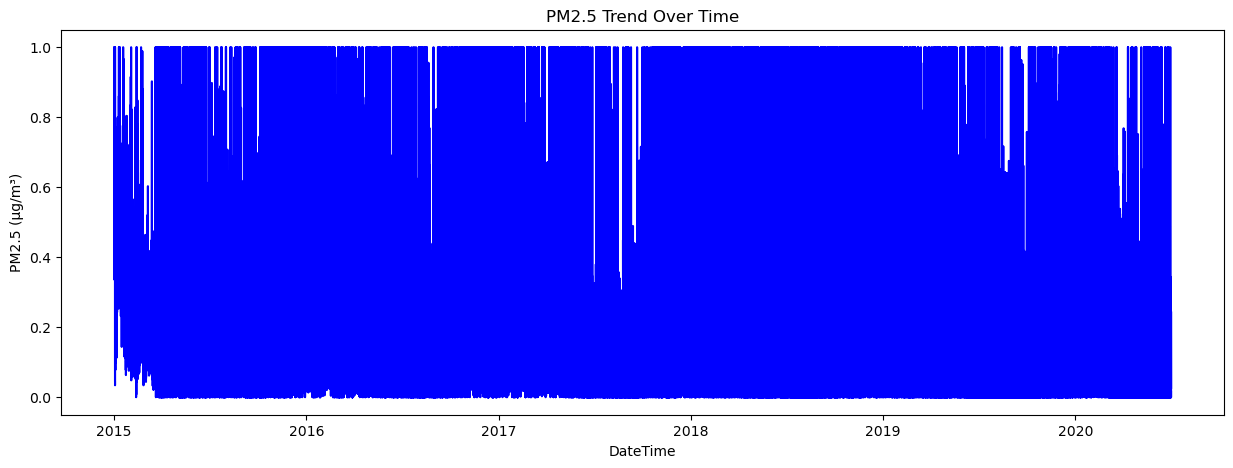

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(df['PM2.5'], color='blue')
plt.title("PM2.5 Trend Over Time")
plt.xlabel("DateTime")
plt.ylabel("PM2.5 (µg/m³)")
plt.show()


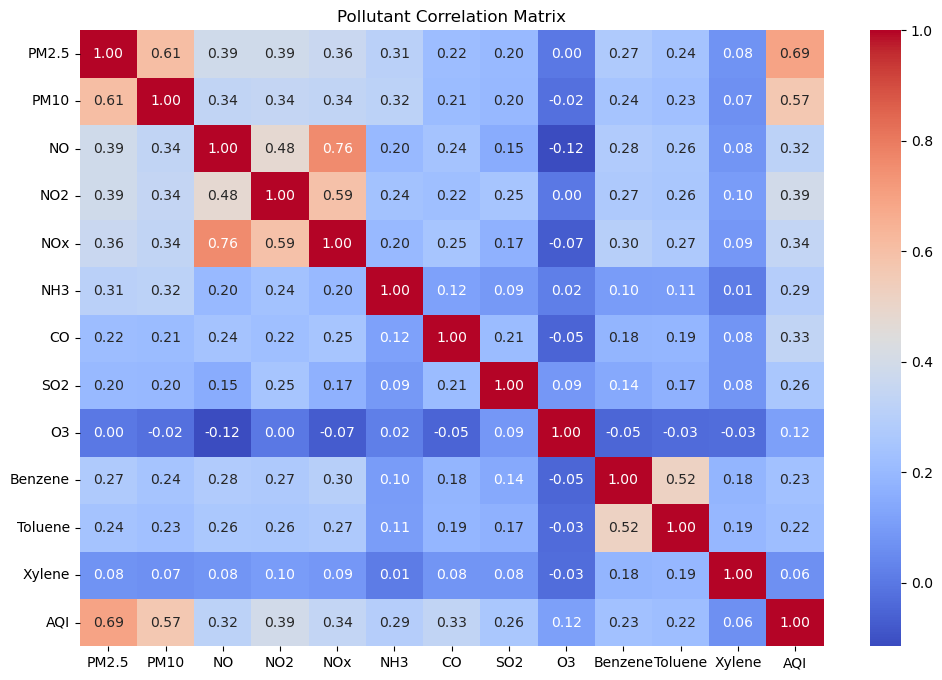

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already loaded and cleaned, with Datetime index
pollutants = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene','AQI']

# Compute correlation matrix
corr = df[pollutants].corr()

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Pollutant Correlation Matrix")
plt.show()


In [ ]:
# Check skew (asymmetry) and kurtosis (peakedness)
df[pollutants].skew()
df[pollutants].kurt()


PM2.5       5.447238
PM10        3.460042
NO         15.980587
NO2         3.876701
NOx         9.995691
NH3         5.350437
CO         26.631071
SO2         8.630066
O3          4.192778
Benzene    14.394902
Toluene    13.413189
Xylene     14.963390
AQI         0.716812
dtype: float64

In [ ]:
import pandas as pd

# Load your CSV
df = pd.read_csv("your_data.csv")

# Example: pick pollutant column
pollutant = "PM2.5"

summary = {
    "Mean": df[pollutant].mean(),
    "Median": df[pollutant].median(),
    "Max": df[pollutant].max(),
    "Min": df[pollutant].min(),
    "Std Dev": df[pollutant].std(),
    "Data Points": df[pollutant].count()
}

print("📊 Summary Statistics:")
for k, v in summary.items():
    print(f"{k}: {v:.2f}")
